In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

Lets just download CIFAR10 train and test dataset and create dataloader objects.

In [2]:
# grabbing cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# images to tensor and normalizing values to [-1, 1] range on each one of the 3 channels(R,G,B)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Visualizing image number of channels, shape and normalization

In [4]:
# Grab a sample image
tensor, label = trainset[0]
print(tensor.shape)
print(tensor)

torch.Size([3, 32, 32])
tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1

frog


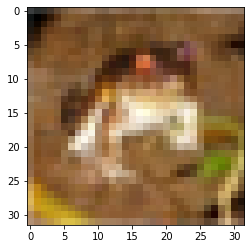

In [5]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# view last printed tensor image and correct label
print(classes[label])
imshow(tensor)

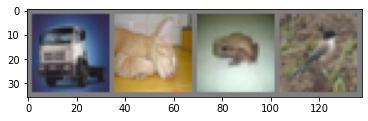

truck             cat            frog            bird


In [6]:
# get a batch of images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('           '.join('%5s' % classes[labels[j]] for j in range(4)))

### Creating the Convolutional Neural Network

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.cv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 possible classes

    def forward(self, x):
        x = self.pool(F.relu(self.cv1(x)))  # using ReLU as activation func, then pooling on results
        x = self.pool(F.relu(self.cv2(x)))  # using ReLU as activation func, then pooling on results
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Criterion is CrossEntropyLoss, its ok to leave it like that
        return x

mdl = CNN().to(device)

Setting the loss function and selecting an optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mdl.parameters(), lr=0.001, momentum=0.9)

Training and evaluating the model

In [9]:
min_val_loss = None
best_mdl = None
len_trainset = len(trainset)
len_testset = len(testset)
early_stop_count = 0
for epoch in range(5):  # loop over the dataset multiple times
    print("\nEPOCH:", epoch)
    train_running_loss = 0
    val_running_loss = 0
    mdl.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = mdl(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    train_avg_loss = train_running_loss/len_trainset
    
    with torch.no_grad():
        mdl.eval()
        val_running_loss = 0
        for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = mdl(inputs)
            val_loss = criterion(outputs, labels).item()
            val_running_loss += loss.item()
    val_avg_loss = val_running_loss/len_testset
            
    print(f"  Train loss: {train_avg_loss}\nValid loss: {val_avg_loss}")
    if min_val_loss == None or val_avg_loss < min_val_loss:
        min_val_loss = val_avg_loss
        best_mdl = mdl.state_dict()
    else:
        early_stop_count += 1
    if early_stop_count == 2:
        print("Early stopping on epoch", epoch)
        break

print('Finished Training')


EPOCH: 0
  Train loss: 0.4043166980192065
Valid loss: 0.5750203132629395

EPOCH: 1
  Train loss: 0.31004984851405026
Valid loss: 0.2807096540927887

EPOCH: 2
  Train loss: 0.26638707899354397
Valid loss: 0.0513790100812912

EPOCH: 3
  Train loss: 0.2402659968927689
Valid loss: 0.15363189578056335

EPOCH: 4
  Train loss: 0.22185621606528527
Valid loss: 0.2877337634563446
Early stopping on epoch 4
Finished Training


In [10]:
torch.save(best_mdl, './cifar10_cnn.pth')

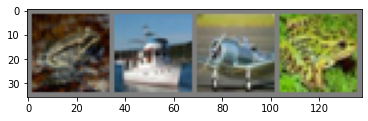

GroundTruth:   frog  ship plane  frog


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
mdl = CNN()
mdl.load_state_dict(torch.load('./cifar10_cnn.pth'))
mdl.to(device)

CNN(
  (cv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
outputs = mdl(images.to(device))

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  ship plane  frog


In [17]:
correct = 0
total = 0
with torch.no_grad():
    mdl.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = mdl(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %


In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    mdl.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = mdl(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 76 %
Accuracy of   car : 79 %
Accuracy of  bird : 53 %
Accuracy of   cat : 43 %
Accuracy of  deer : 62 %
Accuracy of   dog : 57 %
Accuracy of  frog : 81 %
Accuracy of horse : 70 %
Accuracy of  ship : 70 %
Accuracy of truck : 71 %
